In [1]:
import sys
sys.path.append("../src")

import os
from pathlib import Path
from typing import List, Tuple

# Third-Party Imports
import cv2
import pyvips
import tifffile
import numpy as np
from tqdm import tqdm
from empatches import EMPatches
import matplotlib.pyplot as plt

# Local Imports
from utils import get_args, save_patch_args

/Users/ericmonzon/mambaforge/envs/histology/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
data_dir = os.path.join("..", "..", "raw-data", "patches", "experiment-0", "10336")
img_names = os.listdir(data_dir)

print("num images:", len(img_names))

num images: 2949


In [4]:
def extract_coords(img_name: List[str]):

    stem = Path(img_name).stem
    y1, y2, x1, x2 = [int(c) for c in stem.split("-")[1:]]
    coords = (y1, y2, x1, x2)

    return coords


def adjust_coords(
    coords: List[int], 
    src_patch_size: int, 
    target_patch_size: int
    ):

    scaling_factor = src_patch_size / target_patch_size

    adjusted_coords = []

    for coord in coords:
        adjusted = [int(c / scaling_factor) for c in coord]

        adjusted_coords.append(adjusted)

    return adjusted_coords

In [5]:
img_paths = [os.path.join(data_dir, i) for i in img_names]
img_patches = [pyvips.Image.new_from_file(f).numpy() for f in img_paths]

new_size = (1, 1)
resized_image_patches = [cv2.resize(image, new_size) for image in img_patches]

In [6]:
coords = [extract_coords(path) for path in img_paths]

coords

[(34272, 34496, 32256, 32480),
 (34496, 34720, 32256, 32480),
 (34720, 34944, 32256, 32480),
 (48608, 48832, 32256, 32480),
 (48832, 49056, 32256, 32480),
 (34496, 34720, 32480, 32704),
 (45920, 46144, 32480, 32704),
 (47040, 47264, 32480, 32704),
 (47264, 47488, 32480, 32704),
 (47936, 48160, 32480, 32704),
 (48160, 48384, 32480, 32704),
 (48384, 48608, 32480, 32704),
 (48608, 48832, 32480, 32704),
 (48832, 49056, 32480, 32704),
 (46816, 47040, 32704, 32928),
 (47040, 47264, 32704, 32928),
 (47264, 47488, 32704, 32928),
 (47488, 47712, 32704, 32928),
 (47712, 47936, 32704, 32928),
 (47936, 48160, 32704, 32928),
 (48160, 48384, 32704, 32928),
 (48384, 48608, 32704, 32928),
 (48608, 48832, 32704, 32928),
 (48832, 49056, 32704, 32928),
 (45696, 45920, 32928, 33152),
 (45920, 46144, 32928, 33152),
 (46144, 46368, 32928, 33152),
 (46816, 47040, 32928, 33152),
 (47040, 47264, 32928, 33152),
 (47264, 47488, 32928, 33152),
 (47488, 47712, 32928, 33152),
 (47712, 47936, 32928, 33152),
 (47936,

In [7]:
adjusted_coords = adjust_coords(coords, 224, 1)

adjusted_coords

[[153, 154, 144, 145],
 [154, 155, 144, 145],
 [155, 156, 144, 145],
 [217, 218, 144, 145],
 [218, 219, 144, 145],
 [154, 155, 145, 146],
 [205, 206, 145, 146],
 [210, 211, 145, 146],
 [211, 212, 145, 146],
 [214, 215, 145, 146],
 [215, 216, 145, 146],
 [216, 217, 145, 146],
 [217, 218, 145, 146],
 [218, 219, 145, 146],
 [209, 210, 146, 147],
 [210, 211, 146, 147],
 [211, 212, 146, 147],
 [212, 213, 146, 147],
 [213, 214, 146, 147],
 [214, 215, 146, 147],
 [215, 216, 146, 147],
 [216, 217, 146, 147],
 [217, 218, 146, 147],
 [218, 219, 146, 147],
 [204, 205, 147, 148],
 [205, 206, 147, 148],
 [206, 207, 147, 148],
 [209, 210, 147, 148],
 [210, 211, 147, 148],
 [211, 212, 147, 148],
 [212, 213, 147, 148],
 [213, 214, 147, 148],
 [214, 215, 147, 148],
 [215, 216, 147, 148],
 [216, 217, 147, 148],
 [217, 218, 147, 148],
 [218, 219, 147, 148],
 [204, 205, 148, 149],
 [205, 206, 148, 149],
 [206, 207, 148, 149],
 [207, 208, 148, 149],
 [208, 209, 148, 149],
 [209, 210, 148, 149],
 [210, 211,

In [8]:
def merge_patches(patches, coords, new_size):
    orig_height = 384 * new_size
    orig_width = 384 * new_size
    
    num_channels = patches[0].shape[-1]
    merged_img = np.zeros((orig_height, orig_width, num_channels), dtype=np.float32)

    for i, coord in enumerate(coords):
        merged_img[coord[0] : coord[1], coord[2] : coord[3], :] = patches[i]

    return merged_img

In [9]:
merged = merge_patches(resized_image_patches, adjusted_coords, 1).astype("uint8")

In [10]:
merged.shape

(384, 384, 3)

In [11]:
merged.dtype

dtype('uint8')

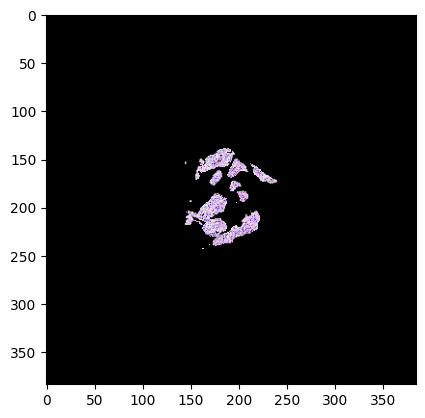

In [12]:
plt.imshow(merged)
plt.show()

In [13]:
plt.imsave("test.png", merged.astype("uint8"))